In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline

from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import fetch_california_housing

## MLLytics Packages

In [2]:
from MLLytics.interpretation import make_pdp, plot_pdp

## Some model

In [3]:
cal_housing = fetch_california_housing()
X = pd.DataFrame(cal_housing.data, columns=cal_housing.feature_names)
y = cal_housing.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,
                                                    random_state=0)

print("Training MLPRegressor...")
est = make_pipeline(QuantileTransformer(),
                    MLPRegressor(hidden_layer_sizes=(50, 50),
                                 learning_rate_init=0.01,
                                 early_stopping=True))
est.fit(X_train, y_train)
print("Test R2 score: {:.2f}".format(est.score(X_test, y_test)))

Training MLPRegressor...
Test R2 score: 0.81


## Single plot

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb8c95f5a50>)

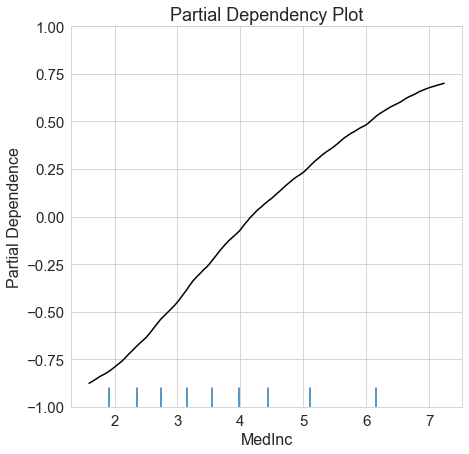

In [4]:
va, li, qtls = make_pdp(X_train, 'MedInc', est, type='regression')
keywords = {'ymin':-1, 'ymax':1}
plot_pdp('MedInc', va, li,type='regression', quantiles=qtls, norm=True, **keywords)

## Multiple plots

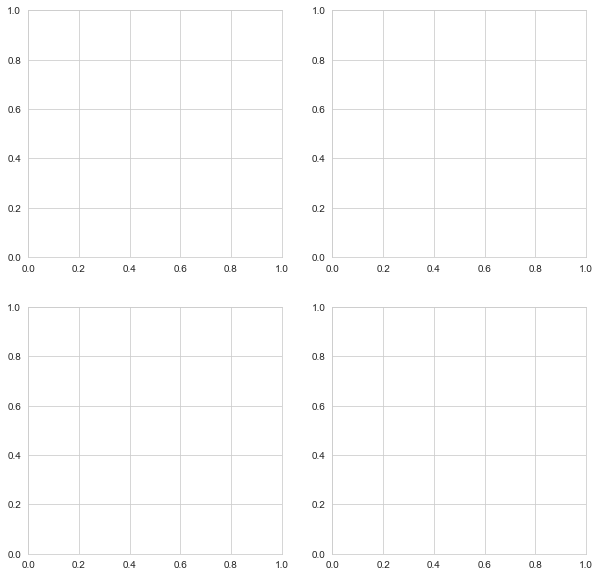

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))

In [6]:
keywords = {'ymin':-1, 'ymax':1, 'title':None}

va, li, qtls = make_pdp(X_train, 'AveOccup', est, type='regression')
plot_pdp('AveOccup', va, li,type='regression', quantiles=qtls, norm=True, ylim=[-1,1], axs=axs[0][0], **keywords)

va, li, qtls = make_pdp(X_train, 'MedInc', est, type='regression')
plot_pdp('MedInc', va, li,type='regression', quantiles=qtls, norm=True, ylim=[-1,1], axs=axs[0][1], **keywords)

va, li, qtls = make_pdp(X_train, 'HouseAge', est, type='regression')
plot_pdp('HouseAge', va, li,type='regression', quantiles=qtls, norm=True, ylim=[-1,1], axs=axs[1][0], **keywords)

va, li, qtls = make_pdp(X_train, 'AveRooms', est, type='regression')
plot_pdp('AveRooms', va, li,type='regression', quantiles=qtls, norm=True, ylim=[-1,1], axs=axs[1][1], **keywords)

In [7]:
fig.suptitle("Partial Dependency plots example", fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.92)


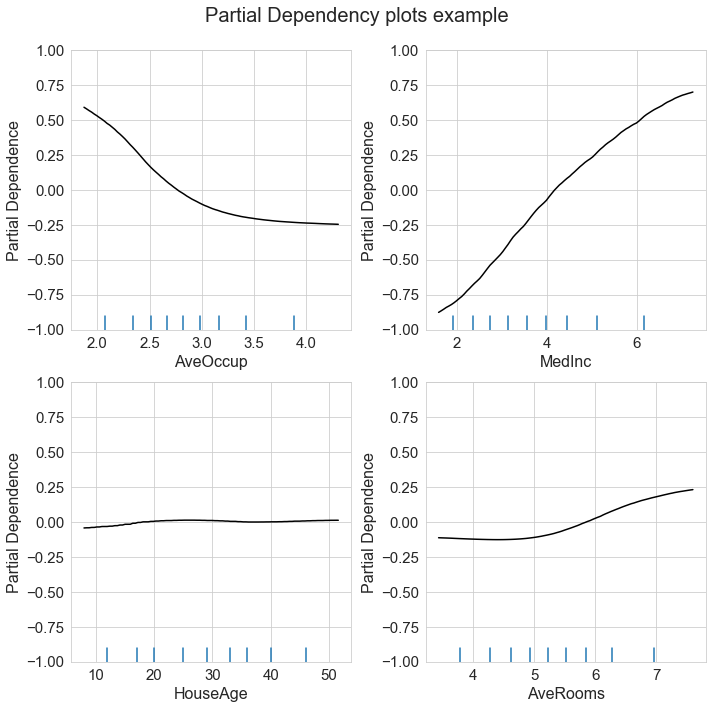

In [8]:
fig

## Edit one of the plots easily 

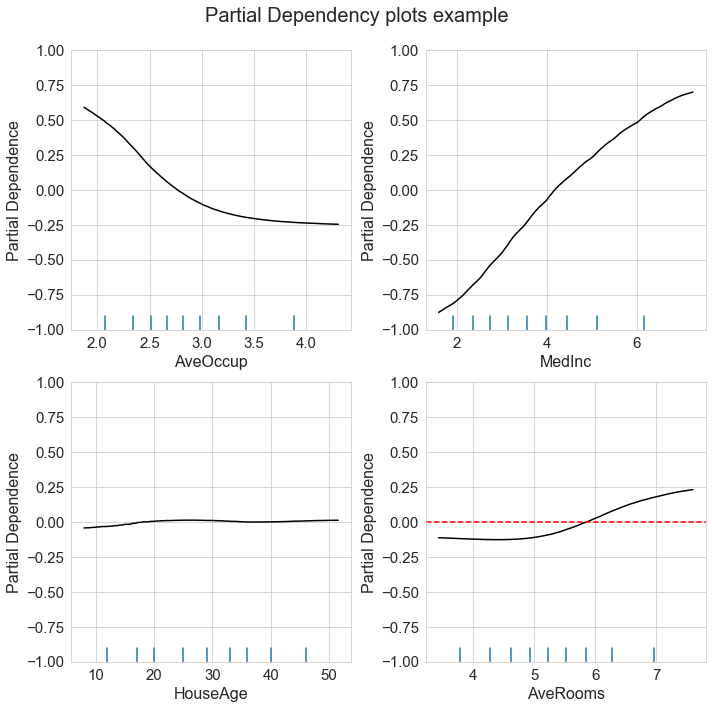

In [9]:
axs[1][1].axhline(0.0, 0, 1.0, linestyle='--', color='red')
fig